In [1]:
# 引入依赖库
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn import preprocessing
from models import BidirectionalLSTM,STC,LSTMMain,LSTM
from module import ScaledDotProductAttention,TemporalConvNet,TemporalBlock,KAN
from utils import *
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import os
from Net import *

/root/miniconda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# 必要参数定义
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 训练设备,如果NVIDIA GPU已配置，会自动使用GPU训练
train_ratio = 0.8  # 训练集比例
val_ratio = 0.1 # 验证集比例
test_ratio = 0.1  # 测试集比例
batch_size = 50  # 批大小，若用CPU，建议为1
input_length = 4  # 每个batch的输入数据长度，多步预测建议长，单步预测建议短
output_length = 1  # 每个batch的输出数据长度，1为单步预测，1以上为多步预测
loss_function = 'MSE'  # 损失函数定义
learning_rate = 0.001  # 基础学习率
weight_decay = 0.001  # 权重衰减系数
num_blocks = 2  # lstm堆叠次数
dim = 128  # 隐层维度
interval_length = 55000  # 预测数据长度，最长不可以超过总数据条数
scalar = True  # 是否使用归一化
scalar_contain_labels = True  # 归一化过程是否包含目标值的历史数据
target_value = 'Temperature (C)'  # 需要预测的列名，可以在excel中查看
# 多步，单步标签
if output_length > 1:
    forecasting_model = 'multi_steps'
else:
    forecasting_model = 'one_steps'

In [3]:
csv_path = "./weatherHistory.csv"
df = pd.read_csv(csv_path)

In [4]:
print(df.shape)

(96453, 8)


In [5]:
df.head()

,date,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,2006-04-01 00:00:00.000 +0200,9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13
1,2006-04-01 01:00:00.000 +0200,9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63
2,2006-04-01 02:00:00.000 +0200,9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94
3,2006-04-01 03:00:00.000 +0200,8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41
4,2006-04-01 04:00:00.000 +0200,8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51


In [6]:
# 原始数据集存在重复项，要进行去重
df.drop_duplicates(subset=["date"],keep='first',inplace=True)

In [7]:
df.shape

(96429, 8)

In [8]:
df.columns

Index(['date', 'Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)'],
      dtype='object')

In [9]:
df.dtypes

date                         object
Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)        int64
Visibility (km)             float64
Pressure (millibars)        float64
dtype: object

In [10]:

# getting the numerical estimates of all the numerical column
df.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
count,96429.000000,96429.000000,96429.000000,96429.000000,96429.000000,96429.000000,96429.000000
mean,11.929692,10.851707,0.734902,10.812460,187.497506,10.347225,1003.232915
std,9.550492,10.695743,0.195466,6.913345,107.376423,4.192548,116.984300
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.683333,2.311111,0.600000,5.828200,116.000000,8.339800,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,1046.380000


In [11]:
# checking null values in our dataset
df.isna().sum()

date                        0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Pressure (millibars)        0
dtype: int64

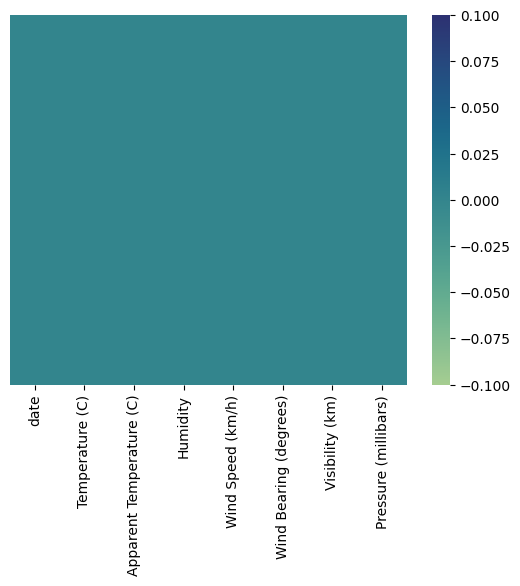

In [12]:
import seaborn as sns
sns.heatmap(df.isna(),yticklabels=False,cmap='crest')
plt.show()

In [13]:
df_1=df.copy()

In [14]:
# getting the datatypes of all the columns having null values
# first storing all the column names in a list having null values
col = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)']
df = df[col]
df[col].dtypes

Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)        int64
Visibility (km)             float64
Pressure (millibars)        float64
dtype: object

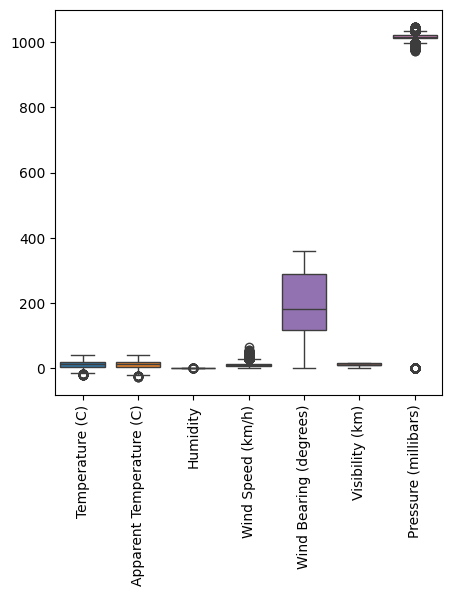

In [15]:
# plotting a boxplot
plt.figure(figsize=(5,5))
sns.boxplot(data=df)
plt.xticks(rotation='vertical')
plt.show()

In [16]:
# getting the quartile one and quartile 3 values of each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
# finally calculating the interquartile range IQR
IQR = Q3 - Q1

In [17]:
# if the values fall behind Q1 - (1.5 * IQR) or above Q3 + 1.5*IQR,
#then it is been defined as outlier
((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

Temperature (C)               44
Apparent Temperature (C)      22
Humidity                      46
Wind Speed (km/h)           3020
Wind Bearing (degrees)         0
Visibility (km)                0
Pressure (millibars)        4400
dtype: int64

In [18]:
mask = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
mask

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
96448,False,False,False,False,False,False,False
96449,False,False,False,False,False,False,False
96450,False,False,False,False,False,False,False
96451,False,False,False,False,False,False,False


In [19]:
for i in mask.columns:
    df[i].astype('float')
    temp = df[i].median()
    df.loc[mask[i], i] = temp

In [20]:
# outliers are now being handled and are replaced with that column's median value
((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()

Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Pressure (millibars)        0
dtype: int64

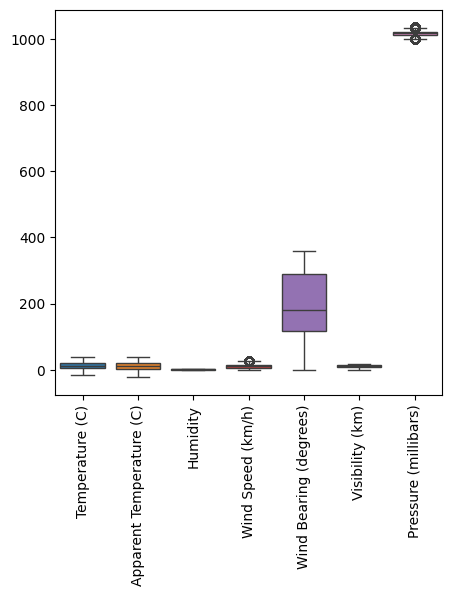

In [21]:
plt.figure(figsize=(5,5))
sns.boxplot(data=df)
plt.xticks(rotation='vertical')
plt.show()

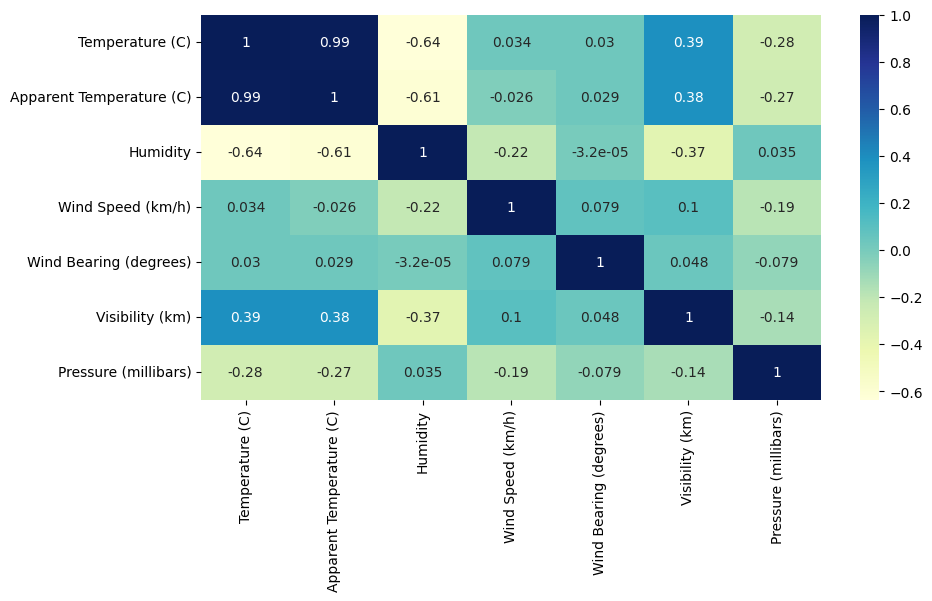

In [22]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),cmap='YlGnBu',annot=True)
plt.show()

In [23]:
feature_keys = [
    'Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)'
]

date_time_key = "date"

In [24]:
df = pd.concat([df_1['date'], df], axis=1)

In [25]:
print(df.head())

                            date  Temperature (C)  Apparent Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200         9.472222                  7.388889   
1  2006-04-01 01:00:00.000 +0200         9.355556                  7.227778   
2  2006-04-01 02:00:00.000 +0200         9.377778                  9.377778   
3  2006-04-01 03:00:00.000 +0200         8.288889                  5.944444   
4  2006-04-01 04:00:00.000 +0200         8.755556                  6.977778   

   Humidity  Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  \
0      0.89            14.1197                     251          15.8263   
1      0.86            14.2646                     259          15.8263   
2      0.89             3.9284                     204          14.9569   
3      0.83            14.1036                     269          15.8263   
4      0.83            11.0446                     259          15.8263   

   Pressure (millibars)  
0               1015.13  
1               1015.6

In [26]:
features = df[feature_keys]
features.index = df[date_time_key]
features.head()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
date,,,,,,,
2006-04-01 00:00:00.000 +0200,9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13
2006-04-01 01:00:00.000 +0200,9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63
2006-04-01 02:00:00.000 +0200,9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94
2006-04-01 03:00:00.000 +0200,8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41
2006-04-01 04:00:00.000 +0200,8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51


In [27]:
df['Date Time'] = pd.to_datetime(df['date'])  # 确保时间列是日期时间格式
df.set_index('Date Time', inplace=True)  # 将时间列设为索引


# 选择目标列和观察列
target = df['Temperature (C)']
observed_cov = df[[ 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)']]

In [28]:
selected_columns = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)']

In [29]:
df_1=df[selected_columns]
df_1.head()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Date Time,,,,,,,
2006-04-01 00:00:00+02:00,9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13
2006-04-01 01:00:00+02:00,9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63
2006-04-01 02:00:00+02:00,9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94
2006-04-01 03:00:00+02:00,8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41
2006-04-01 04:00:00+02:00,8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51


In [30]:
#  读取数据
df = df_1[:interval_length]
features_num = 7  # 请手动输入特征维度数量
if features_num > 1:
    features_ = df.values
else:
    features_ = df[target_value].values
labels_ = df[target_value].values
# 初步划分训练集、验证集、测试集
split_train_val, split_val_test = int(len(features_)*train_ratio),\
                                  int(len(features_)*train_ratio)+int(len(features_)*val_ratio)

In [31]:
#  数据标准化
if scalar:
    #min-max scalar
    train_features_ = features_[:split_train_val]
    val_test_features_ = features_[split_train_val:]
    scalar = preprocessing.MinMaxScaler()
    if features_num == 1:
        train_features_ = np.expand_dims(train_features_, axis=1)
        val_test_features_ = np.expand_dims(val_test_features_, axis=1)
    train_features_ = scalar.fit_transform(train_features_)
    val_test_features_ = scalar.transform(val_test_features_)
    # 重新将数据进行拼接
    features_ = np.vstack([train_features_, val_test_features_])
    if scalar_contain_labels:
        labels_ = features_[:, -1]

if len(features_.shape) == 1:
    features_ = np.expand_dims(features_,0).T
features, labels = get_rolling_window_multistep(output_length, 0, input_length,
                                                features_.T, np.expand_dims(labels_, 0))

data preparing: 100%|██████████| 54996/54996 [00:48<00:00, 1127.52it/s]


In [32]:
#  构建数据集
labels = torch.squeeze(labels, dim=1)
features = features.to(torch.float32)
labels = labels.to(torch.float32)
split_train_val, split_val_test = int(len(features)*train_ratio), int(len(features)*train_ratio)+int(len(features)*val_ratio)
train_features, train_labels = features[:split_train_val], labels[:split_train_val]
val_features, val_labels = features[split_train_val:split_val_test], labels[split_train_val:split_val_test]
test_features, test_labels = features[split_val_test:], labels[split_val_test:]

In [33]:
#  数据管道构建，此处采用torch高阶API
train_Datasets = TensorDataset(train_features.to(device), train_labels.to(device))
train_Loader = DataLoader(batch_size=batch_size, dataset=train_Datasets)
val_Datasets = TensorDataset(val_features.to(device), val_labels.to(device))
val_Loader = DataLoader(batch_size=batch_size, dataset=val_Datasets)
test_Datasets = TensorDataset(test_features.to(device), test_labels.to(device))
test_Loader = DataLoader(batch_size=batch_size, dataset=test_Datasets)

In [34]:
    
class LSTM_KAN(nn.Module):
    def __init__(self, input_size, output_len, lstm_hidden, lstm_layers, batch_size, device="cpu"):
        super(LSTM_KAN, self).__init__()
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.lstmunit = LSTM(input_size, lstm_hidden, lstm_layers, batch_size, device,bidirectional_en = False)
        self.KAN = KAN([lstm_hidden,64,output_len],grid_size=2)
        self.linear = nn.Linear(lstm_hidden,8, output_len)

    def forward(self, input_seq):
        ula, h_out = self.lstmunit(input_seq)
        out = ula.contiguous().view(ula.shape[0] * ula.shape[1], self.lstm_hidden)
        out = self.KAN(out,True)
        #out = self.linear(out)
        out = out.view(ula.shape[0], ula.shape[1], -1)
        out = out[:, -1, :]
        return out

class TCN_LSTM_KAN(nn.Module):
    def __init__(self, input_size, output_len, lstm_hidden, lstm_layers, batch_size, device="cpu"):
        super(TCN_LSTM_KAN, self).__init__()
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.lstmunit = LSTM(input_size , lstm_hidden, lstm_layers, batch_size, device,bidirectional_en = False)
        self.KAN1 = KAN([lstm_hidden,64,output_len],grid_size=2)
        self.tcn = TemporalConvNet(num_inputs=1, num_channels=[1, 1, 1, 1], kernel_size=3, dropout=0.3)
        self.linear = nn.Linear(lstm_hidden, output_len)
    def forward(self, input_seq):        

        #input_seq = input_seq.contiguous()

        #input_seq = self.KAN1(input_seq,True)
        ula, h_out = self.lstmunit(input_seq)
        out = ula.contiguous().view(ula.shape[0] * ula.shape[1], self.lstm_hidden)
        #out = self.KAN1(out)
        out = out.unsqueeze(1)
        out = self.tcn(out)
        out = out.squeeze(1)

        out = self.KAN1(out,True)

        #out = self.linear(out)
        #outclass TCN_LSTM_KAN(nn.Module):
    def __init__(self, input_size, output_len, lstm_hidden, lstm_layers, batch_size, device="cpu"):
        super(TCN_LSTM_KAN, self).__init__()
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.lstmunit = LSTM(input_size , lstm_hidden, lstm_layers, batch_size, device,bidirectional_en = False)
        self.KAN1 = KAN([lstm_hidden,64,output_len],grid_size=2)
        self.tcn = TemporalConvNet(num_inputs=1, num_channels=[1, 1, 1, 1], kernel_size=3, dropout=0.3)
        self.linear = nn.Linear(lstm_hidden, output_len)
    def forward(self, input_seq):        

        #input_seq = input_seq.contiguous()

        #input_seq = self.KAN1(input_seq,True)

        ula, h_out = self.lstmunit(input_seq)
        out = ula.contiguous().view(ula.shape[0] * ula.shape[1], self.lstm_hidden)
        #out = self.KAN1(out)
        out = out.unsqueeze(1)
        out = self.tcn(out)
        out = out.squeeze(1)

        out = self.KAN1(out,True)

        #out = self.linear(out)
        #outclass TCN_LSTM_KAN(nn.Module):
    def __init__(self, input_size, output_len, lstm_hidden, lstm_layers, batch_size, device="cpu"):
        super(TCN_LSTM_KAN, self).__init__()
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.lstmunit = LSTM(input_size , lstm_hidden, lstm_layers, batch_size, device,bidirectional_en = False)
        self.KAN1 = KAN([lstm_hidden,64,output_len],grid_size=2)
        self.tcn = TemporalConvNet(num_inputs=1, num_channels=[1, 1, 1, 1], kernel_size=3, dropout=0.3)
        self.linear = nn.Linear(lstm_hidden, output_len)
    def forward(self, input_seq):        

        #input_seq = input_seq.contiguous()

        #input_seq = self.KAN1(input_seq,True)

        ula, h_out = self.lstmunit(input_seq)
        out = ula.contiguous().view(ula.shape[0] * ula.shape[1], self.lstm_hidden)
        #out = self.KAN1(out)
        out = out.unsqueeze(1)
        out = self.tcn(out)
        out = out.squeeze(1)

        out = self.KAN1(out,True)

        #out = self.linear(out)
        #out = self.KAN1(out,True)
        out = out.view(ula.shape[0], ula.shape[1], -1)

        out = out[:, -1, :]

        return out

class TCN_LSTM(nn.Module):
    def __init__(self, input_size, output_len, lstm_hidden, lstm_layers, batch_size, device="cpu"):
        super(TCN_LSTM, self).__init__()
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.lstmunit = LSTM(input_size , lstm_hidden, lstm_layers, batch_size, device,bidirectional_en = False)
        self.linear = nn.Linear(lstm_hidden, output_len)
        self.tcn = TemporalConvNet(num_inputs=1, num_channels=[1, 1, 1, 1], kernel_size=3, dropout=0.3)

    def forward(self, input_seq):

        ula, h_out = self.lstmunit(input_seq)
        out = ula.contiguous().view(ula.shape[0] * ula.shape[1], self.lstm_hidden)
        out = out.unsqueeze(1)
        out = self.tcn(out)
        out = out.squeeze(1)
        out = self.linear(out)
        out = out.view(ula.shape[0], ula.shape[1], -1)
        out = out[:, -1, :]
        return out
    


In [35]:
#  模型定义


model_name = 'TCN_LSTM_KAN'



if model_name == 'LSTM':
    learning_rate = 0.001
    model = LSTMMain(input_size=features_num, output_len=output_length,
                                  lstm_hidden=dim, lstm_layers=num_blocks, batch_size=batch_size, device=device)
elif model_name == 'LSTM_KAN':
    learning_rate = 0.001
    model = LSTM_KAN(input_size=features_num, output_len=output_length,
                                  lstm_hidden=dim, lstm_layers=num_blocks, batch_size=batch_size, device=device)
elif model_name == 'TCN_LSTM_KAN':
    learning_rate = 0.001
    model = TCN_LSTM_KAN(input_size=features_num, output_len=output_length,
                                  lstm_hidden=dim, lstm_layers=num_blocks, batch_size=batch_size, device=device)
elif model_name == 'TCN_LSTM':
    learning_rate = 0.001
    model = TCN_LSTM(input_size=features_num, output_len=output_length,
                                  lstm_hidden=dim, lstm_layers=num_blocks, batch_size=batch_size, device=device)    
model.to(device)
if loss_function == 'MSE':
    loss_func = nn.MSELoss(reduction='mean')

In [36]:
#  训练代数定义
epochs = 25
#  优化器定义，学习率衰减定义
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3, eta_min=0.00001)

seed = 123
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import r2_score

# Lists to store MAE, RMSE, and R² for each epoch
train_mae_history = []
train_rmse_history = []
train_r2_history = []
val_mae_history = []
val_rmse_history = []
val_r2_history = []

print("——————————————————————Training Starts——————————————————————")
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    # Training
    model.train()
    train_loss_sum = 0
    train_mae_sum = 0
    train_rmse_sum = 0
    all_train_preds = []
    all_train_labels = []
    for step, (feature_, label_) in enumerate(train_Loader):
        optimizer.zero_grad()
        feature_ = feature_.permute(0, 2, 1)
        prediction = model(feature_)
        loss = loss_func(prediction, label_)
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)
        optimizer.step()
        train_loss_sum += loss.item()
        
        # Store predictions and labels for R² calculation
        all_train_preds.append(prediction.detach().cpu().numpy())
        all_train_labels.append(label_.detach().cpu().numpy())
        
        # Calculate MAE and RMSE for this batch
        mae = torch.mean(torch.abs(prediction - label_)).item()
        rmse = torch.sqrt(torch.mean((prediction - label_) ** 2)).item()
        train_mae_sum += mae
        train_rmse_sum += rmse

    # Calculate R² for training data for the entire epoch
    all_train_preds = np.concatenate(all_train_preds)
    all_train_labels = np.concatenate(all_train_labels)
    train_r2 = r2_score(all_train_labels, all_train_preds)
    
    # Record each epoch's metrics
    train_mae_history.append(train_mae_sum / (step + 1))  # Average MAE per epoch
    train_rmse_history.append(train_rmse_sum / (step + 1))  # Average RMSE per epoch
    train_r2_history.append(train_r2)

    print(f"Epoch {epoch}: Train Loss = {train_loss_sum:.4f}, Train MAE = {train_mae_history[-1]:.4f}, Train RMSE = {train_rmse_history[-1]:.4f}, Train R² = {train_r2:.4f}")

    # Validation
    model.eval()
    val_loss_sum = 0
    val_mae_sum = 0
    val_rmse_sum = 0
    all_val_preds = []
    all_val_labels = []
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()
        
        # Store predictions and labels for R² calculation
        all_val_preds.append(prediction.cpu().numpy())
        all_val_labels.append(label_.cpu().numpy())
        
        # Calculate MAE and RMSE for this batch
        mae = torch.mean(torch.abs(prediction - label_)).item()
        rmse = torch.sqrt(torch.mean((prediction - label_) ** 2)).item()
        val_mae_sum += mae
        val_rmse_sum += rmse

    # Calculate R² for validation data for the entire epoch
    all_val_preds = np.concatenate(all_val_preds)
    all_val_labels = np.concatenate(all_val_labels)
    val_r2 = r2_score(all_val_labels, all_val_preds)
    
    # Record each epoch's metrics
    val_mae_history.append(val_mae_sum / (val_step + 1))  # Average MAE per epoch
    val_rmse_history.append(val_rmse_sum / (val_step + 1))  # Average RMSE per epoch
    val_r2_history.append(val_r2)

    print(f"Epoch {epoch}: Val Loss = {val_loss_sum:.4f}, Val MAE = {val_mae_history[-1]:.4f}, Val RMSE = {val_rmse_history[-1]:.4f}, Val R² = {val_r2:.4f}")

    # Save best model
    if epoch == 0 or val_loss_sum < val_best:
        val_best = val_loss_sum
        #torch.save(model.state_dict(), './TCN_LSTM_KAN/TCN_LSTM_KAN_best')  # Save best weights
        print("val_best change")
    '''
    # Save model every 10 epochs
    if epoch % 10 == 0 and epoch >= 10:
        torch.save(model.state_dict(), f'./TCN_LSTM_KAN/TCN_LSTM_KAN_epoch_{epoch}.pth')
        print(f"Model saved at epoch {epoch}")
    '''

print("best val loss = " + str(val_best))
print("——————————————————————Training Ends——————————————————————")


——————————————————————Training Starts——————————————————————


/tmp/ipykernel_16966/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 0: Train Loss = 15.5789, Train MAE = 0.0866, Train RMSE = 0.1019, Train R² = 0.4563
Epoch 0: Val Loss = 0.2514, Val MAE = 0.0275, Val RMSE = 0.0411, Val R² = 0.9244
val_best change


/tmp/ipykernel_16966/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 1: Train Loss = 3.5761, Train MAE = 0.0405, Train RMSE = 0.0560, Train R² = 0.8752
Epoch 1: Val Loss = 0.2196, Val MAE = 0.0241, Val RMSE = 0.0379, Val R² = 0.9339
val_best change


/tmp/ipykernel_16966/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 2: Train Loss = 3.2229, Train MAE = 0.0368, Train RMSE = 0.0526, Train R² = 0.8875
Epoch 2: Val Loss = 0.2219, Val MAE = 0.0250, Val RMSE = 0.0387, Val R² = 0.9333


/tmp/ipykernel_16966/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 3: Train Loss = 3.0003, Train MAE = 0.0344, Train RMSE = 0.0505, Train R² = 0.8953
Epoch 3: Val Loss = 0.2546, Val MAE = 0.0318, Val RMSE = 0.0436, Val R² = 0.9234


/tmp/ipykernel_16966/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 4: Train Loss = 2.8895, Train MAE = 0.0330, Train RMSE = 0.0494, Train R² = 0.8992
Epoch 4: Val Loss = 0.1995, Val MAE = 0.0209, Val RMSE = 0.0360, Val R² = 0.9400
val_best change


/tmp/ipykernel_16966/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 5: Train Loss = 2.8486, Train MAE = 0.0328, Train RMSE = 0.0489, Train R² = 0.9006
Epoch 5: Val Loss = 0.2397, Val MAE = 0.0279, Val RMSE = 0.0411, Val R² = 0.9279


/tmp/ipykernel_16966/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 6: Train Loss = 2.7416, Train MAE = 0.0313, Train RMSE = 0.0478, Train R² = 0.9043
Epoch 6: Val Loss = 0.2168, Val MAE = 0.0244, Val RMSE = 0.0385, Val R² = 0.9348


/tmp/ipykernel_16966/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 7: Train Loss = 2.6635, Train MAE = 0.0300, Train RMSE = 0.0468, Train R² = 0.9070
Epoch 7: Val Loss = 0.1989, Val MAE = 0.0212, Val RMSE = 0.0359, Val R² = 0.9402
val_best change


/tmp/ipykernel_16966/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


In [39]:
np.savez('./plot/TCN_LSTM_KAN_metrics_history.npz', 
         train_mae=train_mae_history, 
         train_mse=train_mse_history, 
         train_r2=train_r2_history, 
         val_mae=val_mae_history, 
         val_mse=val_mse_history, 
         val_r2=val_r2_history)

In [38]:
# 训练及验证循环
print("——————————————————————Training Starts——————————————————————")
for epoch in range(epochs):
    # 训练
    model.train()
    train_loss_sum = 0
    step = 1
    for step, (feature_, label_) in enumerate(train_Loader):
        
        feature_ = feature_.permute(0, 2, 1)

        prediction = model(feature_)

        loss = loss_func(prediction, label_)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)
        
        optimizer.step()
        train_loss_sum += loss.item()
        
    print("epochs = " + str(epoch))
    print('train_loss = ' + str(train_loss_sum))

    # 验证
    model.eval()
    val_loss_sum = 0
    val_step = 1
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()

    if epoch == 0:
        val_best = val_loss_sum
        print('val_loss = ' + str(val_loss_sum))
    else:
        print('val_loss = ' + str(val_loss_sum))
        if val_best > val_loss_sum:
            val_best = val_loss_sum
            torch.save(model.state_dict(), './LSTM_0001/LSTM_best')  # 保存最好权重
            print("val_best changed")

    # 当 epoch >= 10 时，每隔 1 个 epoch 保存一次模型
    if epoch >= 10 and epoch % 1 == 0:
        torch.save(model.state_dict(), f'./LSTM_0001/LSTM_epoch_{epoch}')
        print(f"Model saved at epoch {epoch}")

print("best val loss = " + str(val_best))
print("——————————————————————Training Ends——————————————————————")


——————————————————————Training Starts——————————————————————


/tmp/ipykernel_2844/868793146.py:17: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


epochs = 0
train_loss = 14.007236686506076
val_loss = 0.36316426531993784
epochs = 1
train_loss = 4.305811528221966
val_loss = 0.320917455763265
val_best changed
epochs = 2
train_loss = 4.162169167389948
val_loss = 0.34505498307407834
epochs = 3
train_loss = 4.045738414417428
val_loss = 0.32911129315107246
epochs = 4
train_loss = 3.9630713049882615
val_loss = 0.3358810394529428
epochs = 5
train_loss = 3.915458728086378
val_loss = 0.31828401758684777
val_best changed
epochs = 6
train_loss = 3.867484545768093
val_loss = 0.31737656334007625
val_best changed
epochs = 7
train_loss = 3.8293559368976275
val_loss = 0.298746621938335
val_best changed
epochs = 8
train_loss = 3.801393194591583
val_loss = 0.2955073279517819
val_best changed
epochs = 9
train_loss = 3.765827758335945
val_loss = 0.29231257380888565
val_best changed
epochs = 10
train_loss = 3.7492002948201844
val_loss = 0.2843025718466379
val_best changed
Model saved at epoch 10
epochs = 11
train_loss = 3.721931916250469
val_loss = 0.

In [42]:
# 加载已经训练到第40个epoch的模型权重
model.load_state_dict(torch.load('./LSTM_00001/LSTM_best'))

# 从第41个epoch开始继续训练
start_epoch = 131
epochs = 201  # 设置你想继续训练到的epoch数
# 训练及验证循环
print("——————————————————————Training Starts from Epoch 131——————————————————————")
for epoch in range(start_epoch, epochs+1):  # 从start_epoch开始继续训练
    # 训练
    model.train()
    train_loss_sum = 0
    step = 1
    for step, (feature_, label_) in enumerate(train_Loader):
        
        feature_ = feature_.permute(0, 2, 1)

        prediction = model(feature_)

        loss = loss_func(prediction, label_)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)
        
        optimizer.step()
        train_loss_sum += loss.item()
        
    print("epochs = " + str(epoch))
    print('train_loss = ' + str(train_loss_sum))

    # 验证
    model.eval()
    val_loss_sum = 0
    val_step = 1
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()

    if epoch == start_epoch:
        val_best = val_loss_sum  # 继续训练时，从第41个epoch重新计算best val loss
        print('val_loss = ' + str(val_loss_sum))
    else:
        print('val_loss = ' + str(val_loss_sum))
        if val_best > val_loss_sum:
            val_best = val_loss_sum
            torch.save(model.state_dict(), './TCN_LSTM_KAN_00001/TCN_LSTM_KAN_best_1')  # 保存最好权重
            print("val_best changed")

    # 每隔1个epoch保存一次模型
    if epoch >= 10 and epoch % 1 == 0:
        torch.save(model.state_dict(), f'./TCN_LSTM_KAN_00001/TCN_LSTM_KAN_epoch_{epoch}')
        print(f"Model saved at epoch {epoch}")

print("best val loss = " + str(val_best))
print("——————————————————————Training Ends——————————————————————")

——————————————————————Training Starts from Epoch 131——————————————————————


/tmp/ipykernel_4551/81854735.py:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


epochs = 131
train_loss = 0.24097771075321361
val_loss = 0.025959135440643877
Model saved at epoch 131
epochs = 132
train_loss = 0.23805711811291985
val_loss = 0.02578386984532699
val_best changed
Model saved at epoch 132
epochs = 133
train_loss = 0.23787078421446495
val_loss = 0.025481781020062044
val_best changed
Model saved at epoch 133
epochs = 134
train_loss = 0.2369247408641968
val_loss = 0.02569166134344414
Model saved at epoch 134
epochs = 135
train_loss = 0.23659480712376535
val_loss = 0.02554656902793795
Model saved at epoch 135
epochs = 136
train_loss = 0.23660420093801804
val_loss = 0.025741927849594504
Model saved at epoch 136
epochs = 137
train_loss = 0.23656468407716602
val_loss = 0.02547396527370438
val_best changed
Model saved at epoch 137
epochs = 138
train_loss = 0.23639007136807777
val_loss = 0.02557362910010852
Model saved at epoch 138
epochs = 139
train_loss = 0.235705554834567
val_loss = 0.02574636827921495
Model saved at epoch 139
epochs = 140
train_loss = 0.235

KeyboardInterrupt: 

In [42]:
#  测试集预测
model.load_state_dict(torch.load('./LSTM_0001/LSTM_epoch_24'))  # 调用权重
test_loss_sum = 0
step = 0
#  测试集inference
print("——————————————————————Testing Starts——————————————————————")
for step, (feature_, label_) in enumerate(test_Loader):
    feature_ = feature_.permute(0, 2, 1)
    with torch.no_grad():
         if step ==0:
            prediction = model(feature_)
            pre_array = prediction.cpu()
            label_array = label_.cpu()
            loss = loss_func(prediction, label_)
            test_loss_sum += loss.item()
         else:
            prediction = model(feature_)
            pre_array = np.vstack((pre_array, prediction.cpu()))
            label_array = np.vstack((label_array, label_.cpu()))
            loss = loss_func(prediction, label_)
            test_loss_sum += loss.item()
print("test loss = " + str(test_loss_sum))
print("——————————————————————Testing Ends——————————————————————")

——————————————————————Testing Starts——————————————————————
test loss = 0.2749199158279225
——————————————————————Testing Ends——————————————————————


——————————————————————Post-Processing——————————————————————


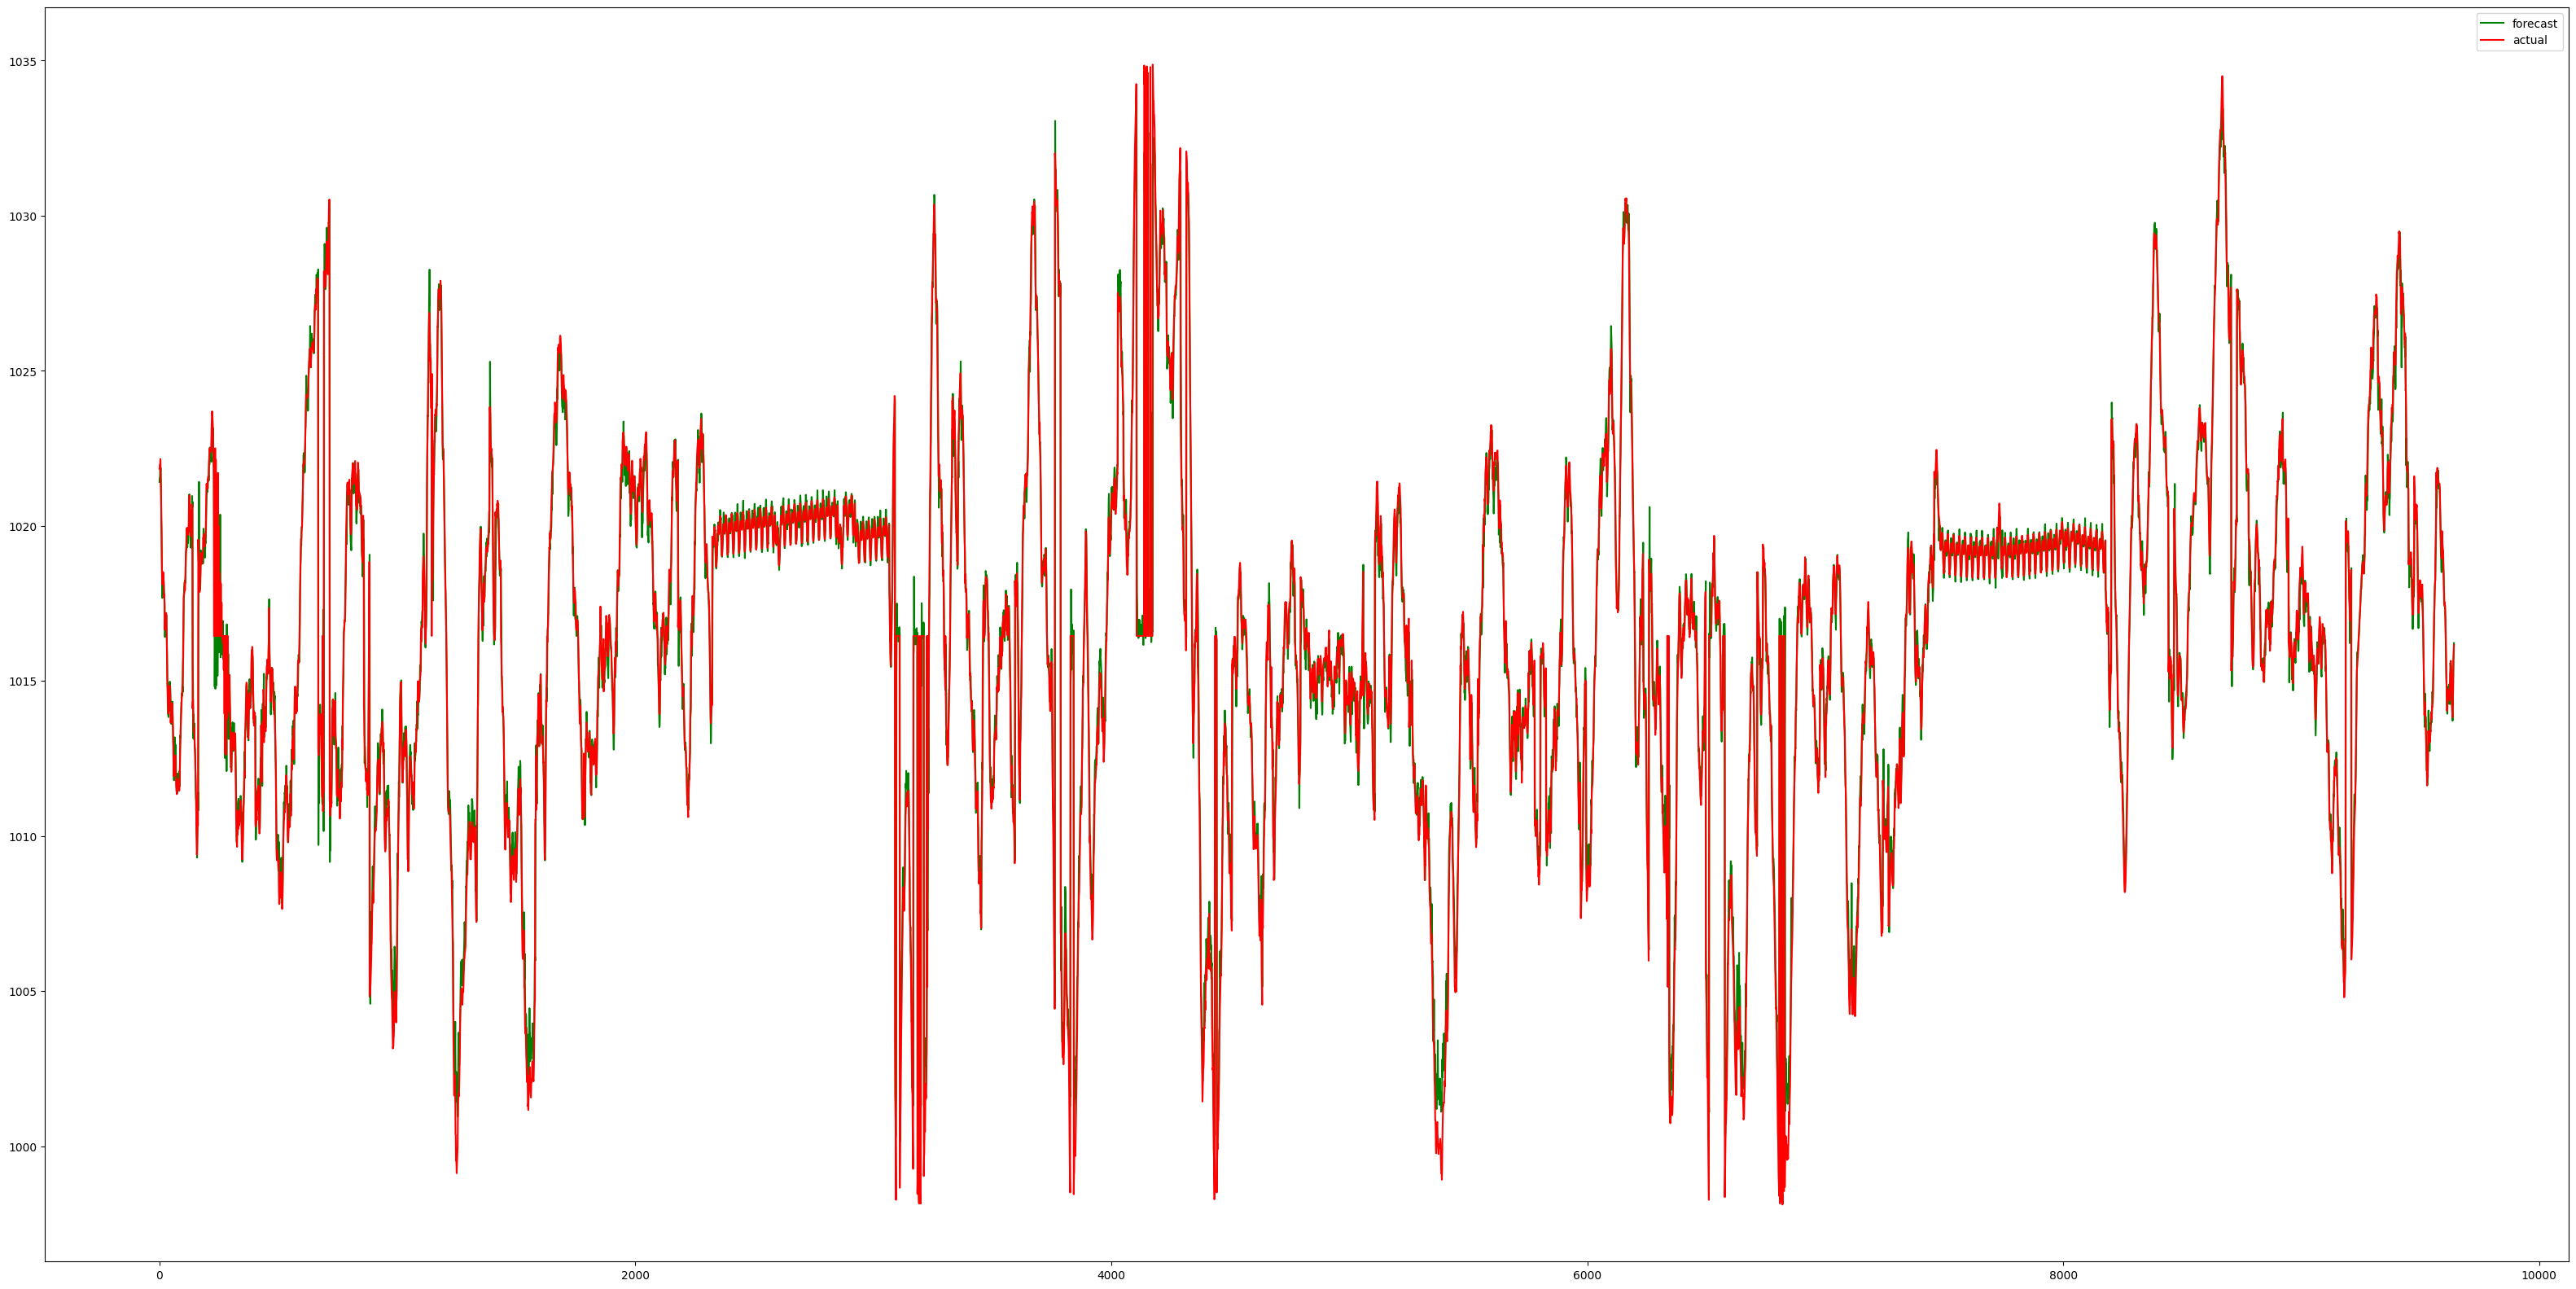

MSE loss=1.925179408597799
MAE loss=0.49340235653041875
MAPE loss=0.0004865490481013945
R2=0.9468386034754604


In [43]:
# 数据后处理，单步预测绘制全部预测值的图像，多步预测仅绘制第一个batch的输出图像
#  逆归一化过程及绘制图像
print("——————————————————————Post-Processing——————————————————————")
#test_labels = torch.tensor(test_labels)

if scalar_contain_labels and scalar :
    pre_inverse = []
    test_inverse = []
    if features_num == 1 and output_length == 1:
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(np.expand_dims(pre_array[pre_slice,:], axis=1))
            test_inverse_slice = scalar.inverse_transform(np.expand_dims(label_array[pre_slice,:], axis=1))
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse).squeeze(axis=-1)
        test_labels = np.array(test_inverse).squeeze(axis=-1)
    elif features_num>1:
        if isinstance(pre_array, np.ndarray):
            pre_array = torch.from_numpy(pre_array)
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(torch.cat((torch.zeros(pre_array[0].shape[0], features_num-1),torch.unsqueeze(pre_array[pre_slice], dim=1)), 1))[:,-1]
            test_inverse_slice = scalar.inverse_transform(torch.cat((torch.zeros(test_labels[0].shape[0], features_num-1), torch.unsqueeze(test_labels[pre_slice], dim=1)), 1))[:,-1]
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse)
        test_labels = np.array(test_inverse)
    else:
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(np.expand_dims(pre_array[pre_slice,:], axis=1))
            test_inverse_slice = scalar.inverse_transform(np.expand_dims(label_array[pre_slice,:], axis=1))
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse).squeeze(axis=-1)
        test_labels = np.array(test_inverse).squeeze(axis=-1)
    plt.figure(figsize=(40,20))
    if forecasting_model == 'multi_steps':
        plt.plot(pre_array[0], 'g')
        plt.plot(test_labels[0], "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    else:
        plt.plot(pre_array, 'g')
        plt.plot(test_labels, "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    #  计算衡量指标
    MSE_l = mean_squared_error(test_labels, pre_array)
    MAE_l = mean_absolute_error(test_labels, pre_array)
    MAPE_l = mean_absolute_percentage_error(test_labels, pre_array)
    R2 = r2_score(test_labels, pre_array)
    print('MSE loss=%s'%MSE_l)
    print('MAE loss=%s'%MAE_l)
    print('MAPE loss=%s'%MAPE_l)
    print('R2=%s'%R2)

else:
    plt.figure(figsize=(40,20))
    if forecasting_model == 'multi_steps':
        plt.plot(pre_array[0], 'g')
        plt.plot(test_labels[0].cpu(), "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    else:
        plt.plot(pre_array, 'g')
        plt.plot(test_labels.cpu(), "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    MSE_l = mean_squared_error(test_labels.cpu(), pre_array)
    MAE_l = mean_absolute_error(test_labels.cpu(), pre_array)
    MAPE_l = mean_absolute_percentage_error(test_labels.cpu(), pre_array)
    R2 = r2_score(test_labels.cpu(), pre_array)
    print('MSE loss=%s'%MSE_l)
    print('MAE loss=%s'%MAE_l)
    print('MAPE loss=%s'%MAPE_l)
    print('R2=%s'%R2)